In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/RIR 2022 Synthetic Data/4-29 Actual Data") #changing working directory to google drive

In [ ]:
!pip install hyperopt
!pip show hyperopt
! git clone https://github.com/hyperopt/hyperopt-sklearn
! cd hyperopt-sklearn/
! pip install hyperopt-sklearn/
! pip install hpsklearn
! pip show hpsklearn
os.chdir("/content/drive/MyDrive/RIR 2022 Synthetic Data/4-29 Actual Data")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Name: hyperopt
Version: 0.2.7
Summary: Distributed Asynchronous Hyperparameter Optimization
Home-page: https://hyperopt.github.io/hyperopt
Author: James Bergstra
Author-email: james.bergstra@gmail.com
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: cloudpickle, future, networkx, numpy, py4j, scipy, six, tqdm
Required-by: 
fatal: destination path 'hyperopt-sklearn' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./hyperopt-sklearn
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hpsklearn: filename=hpsklearn-1.0.3-py3-none-any.whl size=135027 sha256=8c120b6b79e006f90a43034e38cf80f7fd523f1e25db4316d7e040293b48cc43
  Stored in directory: /root/.cache/pip/wh

In [ ]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.stem.snowball import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt') # needed for apply function
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import gensim
import spacy
from random import sample
from hpsklearn import HyperoptEstimator, tfidf,multinomial_nb, sgd_classifier
from hyperopt import tpe
from hyperopt import hp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve,average_precision_score,auc
import scipy.stats as stats
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0.331475
0.2842897278745752
0.2605


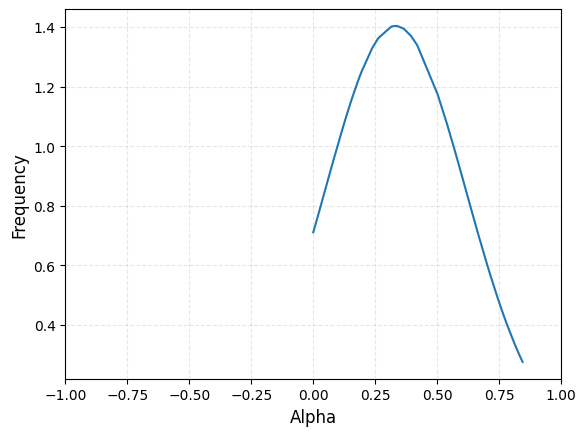

In [ ]:
#This Code chunk is just to find the median from the alpha which has been claculated. Added on 5-29
al = pd.read_csv("out1.csv")
al.head(5)
al_mean = np.mean(al["Alpha"])
print(al_mean)
al_std = np.std(al["Alpha"])
print(al_std)
al_median = np.median(al["Alpha"])
print(al_median)
#calculate the pdf
pdf = stats.norm.pdf(al["Alpha"].sort_values(), al_mean, al_std)
# Drawing a graph
plt.plot(al["Alpha"].sort_values(), pdf)
plt.xlim([-1,1])
plt.xlabel("Alpha", size=12)
plt.ylabel("Frequency", size=12)
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()
# looking at the graph using 0.26

In [ ]:
# remove the hashtags, mentions and unwanted characters.
def remove_content(text):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) # To Remove http, https and the other normal url type special characters
    text=re.sub(r'\S+\.com\S+','',text) #remove urls."" mean no space or nothing
    text=re.sub(r'\@\w+','',text) #remove mentions
    text =re.sub(r'\#\w+','',text) #remove hashtags
    text =re.sub(r"^RT\s+",'',text) #remove rt's. re.sub() used to replace substrings; Syntax: re.sub(pattern,replacement,string) & will replace the matches in string with repl.
    return text

In [ ]:
def process_text(text, stem= False): #clean text
    text=remove_content(text)
    text = re.sub('[^A-Za-z0-9]', ' ', text.lower()) #remove non-alphabets(?); lower is method applied to string text; matching each word in text-replacing with lower version
    tokenized_text = word_tokenize(text) #tokenize
    clean_text = [
         word for word in tokenized_text
         if word not in stopwords.words("english")
    ]
    if stem:
        stemmer = PorterStemmer() # initializig a poterstemmer object
        clean_text=[stemmer.stem(word) for word in clean_text]
    return ' '.join(clean_text)
    #return clean_text

Automating the hyper opt

In [ ]:
#df is train
i = [1,5,10,15]
j = [0,2,5,10]
k = [0,1,2,3,4]
hyper =pd.DataFrame()
file_name=[]
m=[]
h=[]
l=[]
for a in i:
  for b in j:
    for c in k:
      string = str(a)+"_"+str(b)+"_"+str(c)
      print(string)
      file_name += [string]
      #print(file_name)
      f = "/content/drive/MyDrive/RIR 2022 Synthetic Data/4-29 Actual Data/training_set_"+str(a)+"_"+str(b)+"_"+str(c)+".pkl"
      df = pd.read_pickle(f)
      del df["gpt"] #Dropping the column "gpt"
      df =df[["label", "cleaned_input_txt"]] # Changing the order of columns to match Khrys dataset
      df=df.rename(columns={"label":"training label","cleaned_input_txt":"content"})
      df_sample= df.sample(frac=1)
      #Preprocessing Dataset
      df_sample["processed"] = df_sample['content'].apply(lambda x: process_text(x, False))
      df_sample.head(2)
      #Preparing dataset for hyperopt optimization
      X = df_sample.processed
      y = df_sample["training label"]
      #Defining the Search
      estim = HyperoptEstimator(classifier=multinomial_nb("multi"), preprocessing=[tfidf("tfidf",max_features=10000)],algo=tpe.suggest, max_evals=50, trial_timeout=30)
      #performing the search
      estim.fit(X, y)
      #At the end of the run, the best-performing model can be evaluated on new data by calling the score() function
      g = "/content/drive/MyDrive/RIR 2022 Synthetic Data/4-29 Actual Data/val_set_"+str(a)+"_"+str(b)+"_"+str(c)+".pkl"
      df2 = pd.read_pickle(g)
      del df2["gpt"] #Dropping the column "gpt"
      df2 =df2[["label", "cleaned_input_txt"]] # Changing the order of columns to match Khrys dataset
      df2=df2.rename(columns={"label":"training label","cleaned_input_txt":"content"})
      df2["processed"] = df2['content'].apply(lambda x: process_text(x, False))
      X_valid = df2.processed
      y_valid = df2["training label"]
      #vectorizer = TfidfVectorizer(max_features=10000)
      #X_valid_tfidf = vectorizer.fit_transform(X_valid)
      print(estim.score(X_valid,y_valid))
      print(estim.best_model())
      A=estim.trials.best_trial["misc"]["vals"]["multi.multinomial_nb_alpha"]
      B=A[0]
      l.append(B)
      #print(l)
      C=estim.trials.best_trial["misc"]["vals"]["tfidf.tfidf_vectorizer_max_ngram"]
      D=C[0]
      h.append(D)
      #print(h)
      E=estim.trials.best_trial["misc"]["vals"]["tfidf.tfidf_vectorizer_lowercase"]
      #print(type(E))
      F=E[0]
      #print(F)
      m.append(F)
      print(m)
hyper["File"]=file_name
hyper["Alpha"] = l
hyper["ngramMax"] = h
hyper["ngramMin"] = m

1_0_0
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 43/44 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 45/46 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 47/48 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 49/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:04<00:00,  4.77s/trial, best loss: 0.0]
0.723404255319149
{'learner': MultinomialNB(alpha=0.735), 'preprocs': (TfidfVectorizer(max_features=10000, ngram_range=(1, 3), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0]
1_0_1
 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 36/37 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 41/42 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.33s/trial, best loss: 0.0004191114836546994]
0.7659574468085106
{'learner': MultinomialNB(alpha=0.74, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, max_features=10000, ngram_range=(1, 4), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0]
1_0_2
 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 39/40 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:04<00:00,  4.08s/trial, best loss: 0.0]
0.7446808510638298
{'learner': MultinomialNB(alpha=0.106, fit_prior=False), 'preprocs': (TfidfVectorizer(analyzer='char', binary=True, max_features=10000,
                ngram_range=(1, 3), norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0]
1_0_3
 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▌| 25/26 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▋| 26/27 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 28/29 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 30/31 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 31/32 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 32/33 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 33/34 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 34/35 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 35/36 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 38/39 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(



 98%|█████████▊| 47/48 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 49/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:02<00:00,  2.86s/trial, best loss: 0.0004191114836546994]
0.7659574468085106
{'learner': MultinomialNB(alpha=0.005), 'preprocs': (TfidfVectorizer(analyzer='char', lowercase=False, max_features=10000,
                ngram_range=(1, 3), norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1]
1_0_4
 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 30/31 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.46s/trial, best loss: 0.0]
0.7659574468085106
{'learner': MultinomialNB(alpha=0.47900000000000004, fit_prior=False), 'preprocs': (TfidfVectorizer(analyzer='char_wb', lowercase=False, max_features=10000,
                ngram_range=(1, 4), norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1]
1_2_0
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▌| 24/25 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▋| 27/28 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 28/29 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 30/31 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 32/33 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 33/34 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 35/36 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 36/37 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 37/38 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 38/39 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 40/41 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 41/42 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 47/48 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 49/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.35s/trial, best loss: 0.0]


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


0.851063829787234
{'learner': MultinomialNB(alpha=0.334), 'preprocs': (TfidfVectorizer(analyzer='char', max_features=10000, ngram_range=(1, 4),
                norm=None, smooth_idf=False, stop_words='english',
                use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0]
1_2_1
 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 45/46 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  2.07trial/s, best loss: 0.0]
0.7659574468085106
{'learner': MultinomialNB(alpha=0.117), 'preprocs': (TfidfVectorizer(analyzer='char', binary=True, lowercase=False,
                max_features=10000, ngram_range=(1, 4), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1]
1_2_2
 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 36/37 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 41/42 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:04<00:00,  4.55s/trial, best loss: 0.0008382229673092878]
0.851063829787234
{'learner': MultinomialNB(alpha=0.253, fit_prior=False), 'preprocs': (TfidfVectorizer(lowercase=False, max_features=10000, ngram_range=(1, 4),
                norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1]
1_2_3
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 45/46 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 47/48 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 49/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:02<00:00,  2.17s/trial, best loss: 0.0008382229673092878]
0.8936170212765957
{'learner': MultinomialNB(alpha=0.6970000000000001, fit_prior=False), 'preprocs': (TfidfVectorizer(analyzer='char', binary=True, lowercase=False,
                max_features=10000, ngram_range=(1, 4), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1]
1_2_4
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 20/21 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 21/22 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▌| 22/23 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▌| 23/24 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▌| 24/25 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▌| 25/26 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▋| 26/27 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▋| 27/28 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 28/29 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 30/31 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 31/32 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 32/33 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 33/34 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 35/36 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 36/37 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 37/38 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 39/40 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 40/41 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 41/42 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 43/44 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 44/45 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  1.14trial/s, best loss: 0.0]


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


0.7872340425531915
{'learner': MultinomialNB(alpha=0.923), 'preprocs': (TfidfVectorizer(analyzer='char', binary=True, lowercase=False,
                max_features=10000, ngram_range=(1, 4), norm=None,
                smooth_idf=False, stop_words='english', use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1]
1_5_0
 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 40/41 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 42/43 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 47/48 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.34s/trial, best loss: 0.0012573344509639872]
0.8936170212765957
{'learner': MultinomialNB(alpha=0.371, fit_prior=False), 'preprocs': (TfidfVectorizer(max_features=10000, ngram_range=(1, 3), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0]
1_5_1
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 42/43 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:04<00:00,  4.89s/trial, best loss: 0.0012573344509639872]
0.8085106382978723
{'learner': MultinomialNB(alpha=0.026000000000000002, fit_prior=False), 'preprocs': (TfidfVectorizer(analyzer='char', binary=True, max_features=10000,
                ngram_range=(1, 4), norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0]
1_5_2
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 47/48 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  1.32trial/s, best loss: 0.002933780385582563]
0.851063829787234
{'learner': MultinomialNB(alpha=0.4, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, max_features=10000, ngram_range=(1, 4), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]
1_5_3
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 35/36 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 38/39 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 41/42 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 45/46 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:03<00:00,  3.66s/trial, best loss: 0.005029337803855838]
0.851063829787234
{'learner': MultinomialNB(alpha=0.353, fit_prior=False), 'preprocs': (TfidfVectorizer(lowercase=False, max_features=10000, ngram_range=(1, 4),
                norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1]
1_5_4
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 21/22 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▌| 22/23 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▌| 23/24 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▌| 24/25 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▋| 26/27 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▋| 27/28 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 28/29 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 30/31 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 31/32 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 33/34 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 34/35 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 35/36 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 49/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:03<00:00,  3.62s/trial, best loss: 0.0]


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


0.8936170212765957
{'learner': MultinomialNB(alpha=0.20600000000000002, fit_prior=False), 'preprocs': (TfidfVectorizer(analyzer='char', binary=True, lowercase=False,
                max_features=10000, ngram_range=(1, 4), norm=None,
                smooth_idf=False, stop_words='english', use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1]
1_10_0
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 42/43 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 47/48 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.29s/trial, best loss: 0.0016764459346185756]
0.9148936170212766
{'learner': MultinomialNB(alpha=0.337), 'preprocs': (TfidfVectorizer(max_features=10000, ngram_range=(1, 4), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0]
1_10_1
 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 44/45 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.72s/trial, best loss: 0.0016764459346185756]
0.8936170212765957
{'learner': MultinomialNB(alpha=0.012), 'preprocs': (TfidfVectorizer(lowercase=False, max_features=10000, ngram_range=(1, 3),
                norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1]
1_10_2
 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 44/45 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 46/47 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:02<00:00,  2.17s/trial, best loss: 0.0016764459346185756]
0.8936170212765957
{'learner': MultinomialNB(alpha=0.40800000000000003, fit_prior=False), 'preprocs': (TfidfVectorizer(lowercase=False, max_features=10000, ngram_range=(1, 4),
                norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1]
1_10_3
 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 35/36 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 37/38 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 41/42 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 44/45 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:05<00:00,  5.15s/trial, best loss: 0.0037720033528918506]
0.9361702127659575
{'learner': MultinomialNB(alpha=0.059000000000000004, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, lowercase=False, max_features=10000,
                ngram_range=(1, 4), norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1]
1_10_4
 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:02<00:00,  2.61s/trial, best loss: 0.0012573344509639872]
0.9787234042553191
{'learner': MultinomialNB(alpha=0.20600000000000002, fit_prior=False), 'preprocs': (TfidfVectorizer(max_features=10000, ngram_range=(1, 3), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0]
5_0_0
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 43/44 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.41s/trial, best loss: 0.0017174753112924046]
0.8
{'learner': MultinomialNB(alpha=0.481, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, max_features=10000, ngram_range=(1, 4), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0]
5_0_1
 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.41s/trial, best loss: 0.0012881064834693312]
0.8166666666666667
{'learner': MultinomialNB(alpha=0.666, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, max_features=10000, ngram_range=(1, 4), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0]
5_0_2
 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:02<00:00,  2.25s/trial, best loss: 0.004293688278230956]
0.7958333333333333
{'learner': MultinomialNB(alpha=0.013000000000000001), 'preprocs': (TfidfVectorizer(binary=True, lowercase=False, max_features=10000,
                ngram_range=(1, 3), norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1]
5_0_3
 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 39/40 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 41/42 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 44/45 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 47/48 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:02<00:00,  2.75s/trial, best loss: 0.0012881064834693312]
0.8041666666666667
{'learner': MultinomialNB(alpha=0.026000000000000002, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, max_features=10000, ngram_range=(1, 4), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
5_0_4
 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 21/22 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▋| 26/27 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 31/32 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 32/33 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 35/36 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 36/37 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 38/39 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 44/45 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.09s/trial, best loss: 0.0025751072961373023]
0.826271186440678
{'learner': MultinomialNB(alpha=0.17, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, max_features=10000, ngram_range=(1, 4), norm=None,
                smooth_idf=False, stop_words='english', use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0]
5_2_0
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 44/45 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  2.50trial/s, best loss: 0.003434950622584809]
0.9291666666666667
{'learner': MultinomialNB(alpha=0.8290000000000001), 'preprocs': (TfidfVectorizer(binary=True, lowercase=False, max_features=10000,
                ngram_range=(1, 2), norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1]
5_2_1
 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 33/34 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 36/37 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 39/40 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  2.54trial/s, best loss: 0.006869901245169618]
0.9208333333333333
{'learner': MultinomialNB(alpha=0.803), 'preprocs': (TfidfVectorizer(max_features=10000, ngram_range=(1, 2), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0]
5_2_2
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.10s/trial, best loss: 0.009016745384285096]
0.8666666666666667
{'learner': MultinomialNB(alpha=0.352), 'preprocs': (TfidfVectorizer(max_features=10000, ngram_range=(1, 3), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]
5_2_3
 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:02<00:00,  2.64s/trial, best loss: 0.005581794761700287]
0.9333333333333333
{'learner': MultinomialNB(alpha=0.548), 'preprocs': (TfidfVectorizer(max_features=10000, ngram_range=(1, 2), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
5_2_4
 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 35/36 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 42/43 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 47/48 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  1.31trial/s, best loss: 0.0038626609442059534]
0.9194915254237288
{'learner': MultinomialNB(alpha=0.042, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, max_features=10000, ngram_range=(1, 2), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
5_5_0
 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 34/35 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(



 97%|█████████▋| 35/36 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 36/37 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 38/39 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 39/40 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 42/43 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 43/44 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 45/46 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 47/48 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 49/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:02<00:00,  2.09s/trial, best loss: 0.008587376556462023]
0.9458333333333333
{'learner': MultinomialNB(alpha=0.112), 'preprocs': (TfidfVectorizer(binary=True, max_features=10000, ngram_range=(1, 2), norm=None,
                smooth_idf=False, stop_words='english', use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
5_5_1
 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 37/38 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 40/41 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 43/44 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 46/47 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:02<00:00,  2.18s/trial, best loss: 0.00944611421210817]
0.9583333333333334
{'learner': MultinomialNB(alpha=0.793, fit_prior=False), 'preprocs': (TfidfVectorizer(max_features=10000, ngram_range=(1, 2), norm=None,
                smooth_idf=False, stop_words='english', use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
5_5_2
 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 46/47 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.69s/trial, best loss: 0.007728638900815765]
0.9041666666666667
{'learner': MultinomialNB(alpha=0.003), 'preprocs': (TfidfVectorizer(binary=True, lowercase=False, max_features=10000,
                ngram_range=(1, 2), norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]
5_5_3
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 32/33 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 39/40 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 44/45 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 45/46 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.07s/trial, best loss: 0.014598540145985384]
0.9583333333333334
{'learner': MultinomialNB(alpha=0.289, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, lowercase=False, max_features=10000,
                ngram_range=(1, 2), norm=None, smooth_idf=False,
                stop_words='english', use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
5_5_4
 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 45/46 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 47/48 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.83s/trial, best loss: 0.009871244635193177]
0.9322033898305084
{'learner': MultinomialNB(alpha=0.004, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, max_features=10000, norm=None, smooth_idf=False,
                use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]
5_10_0
 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  1.29trial/s, best loss: 0.009875483039931354]
0.9458333333333333
{'learner': MultinomialNB(alpha=0.10300000000000001, fit_prior=False), 'preprocs': (TfidfVectorizer(lowercase=False, max_features=10000, ngram_range=(1, 2),
                norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1]
5_10_1
 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 46/47 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  1.29trial/s, best loss: 0.018033490768570193]
0.9208333333333333
{'learner': MultinomialNB(alpha=0.002), 'preprocs': (TfidfVectorizer(max_features=10000, ngram_range=(1, 2), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
5_10_2
 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 47/48 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 49/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.22s/trial, best loss: 0.018033490768570193]
0.8958333333333334
{'learner': MultinomialNB(alpha=0.003, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, lowercase=False, max_features=10000, norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1]
5_10_3
 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 37/38 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 46/47 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  2.68trial/s, best loss: 0.015027908973808457]
0.9625
{'learner': MultinomialNB(alpha=0.54, fit_prior=False), 'preprocs': (TfidfVectorizer(lowercase=False, max_features=10000, ngram_range=(1, 2),
                norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1]
5_10_4
 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 37/38 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 41/42 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 42/43 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 47/48 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 49/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  1.10trial/s, best loss: 0.011587982832617971]
0.9449152542372882
{'learner': MultinomialNB(alpha=0.038, fit_prior=False), 'preprocs': (TfidfVectorizer(lowercase=False, max_features=10000, norm=None,
                smooth_idf=False, stop_words='english', use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
10_0_0
 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 32/33 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 34/35 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 36/37 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 38/39 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 40/41 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 41/42 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 44/45 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 45/46 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 49/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.40s/trial, best loss: 0.003083700440528636]
0.8584474885844748
{'learner': MultinomialNB(alpha=0.7000000000000001, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, max_features=10000, ngram_range=(1, 4), norm=None,
                smooth_idf=False, stop_words='english', use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0]
10_0_1
 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 37/38 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 40/41 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 42/43 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 43/44 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 46/47 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 47/48 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 49/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:04<00:00,  4.21s/trial, best loss: 0.0035460992907800915]
0.8533057851239669
{'learner': MultinomialNB(alpha=0.197), 'preprocs': (TfidfVectorizer(binary=True, lowercase=False, max_features=10000,
                ngram_range=(1, 3), norm=None, smooth_idf=False,
                stop_words='english', use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1]
10_0_2
 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 44/45 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.30s/trial, best loss: 0.00310008857395927]
0.8708333333333333
{'learner': MultinomialNB(alpha=0.017), 'preprocs': (TfidfVectorizer(binary=True, max_features=10000, ngram_range=(1, 2), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0]
10_0_3
 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 46/47 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  1.27trial/s, best loss: 0.003542958370239102]
0.8666666666666667
{'learner': MultinomialNB(alpha=0.139, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, lowercase=False, max_features=10000,
                ngram_range=(1, 2), norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1]
10_0_4
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▌| 22/23 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.77s/trial, best loss: 0.0057547587428065095]
0.8676470588235294
{'learner': MultinomialNB(alpha=0.035), 'preprocs': (TfidfVectorizer(max_features=10000, ngram_range=(1, 3), norm=None,
                smooth_idf=False, stop_words='english', use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0]
10_2_0
 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 46/47 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  2.38trial/s, best loss: 0.012775330396475826]
0.9360730593607306
{'learner': MultinomialNB(alpha=0.016, fit_prior=False), 'preprocs': (TfidfVectorizer(lowercase=False, max_features=10000, ngram_range=(1, 2),
                norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1]
10_2_1
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 36/37 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 37/38 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 39/40 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 42/43 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 46/47 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  2.32trial/s, best loss: 0.01817375886524819]
0.871900826446281
{'learner': MultinomialNB(alpha=0.002), 'preprocs': (TfidfVectorizer(binary=True, lowercase=False, max_features=10000, norm=None,
                smooth_idf=False, stop_words='english', use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1]
10_2_2
 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  1.25trial/s, best loss: 0.018157661647475676]
0.9083333333333333
{'learner': MultinomialNB(alpha=0.145, fit_prior=False), 'preprocs': (TfidfVectorizer(max_features=10000, ngram_range=(1, 2), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0]
10_2_3
 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 31/32 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(



100%|██████████| 50/50 [00:02<00:00,  2.24s/trial, best loss: 0.018600531443755508]
0.9083333333333333
{'learner': MultinomialNB(alpha=0.009000000000000001, fit_prior=False), 'preprocs': (TfidfVectorizer(lowercase=False, max_features=10000, ngram_range=(1, 2),
                norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1]
10_2_4
 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 38/39 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 46/47 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:02<00:00,  2.92s/trial, best loss: 0.01726427622841964]
0.907563025210084
{'learner': MultinomialNB(alpha=0.007, fit_prior=False), 'preprocs': (TfidfVectorizer(lowercase=False, max_features=10000, norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1]
10_5_0
 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 33/34 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 37/38 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  1.13trial/s, best loss: 0.018061674008810535]
0.9041095890410958
{'learner': MultinomialNB(alpha=0.027, fit_prior=False), 'preprocs': (TfidfVectorizer(lowercase=False, max_features=10000, norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1]
10_5_1
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 33/34 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 35/36 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 37/38 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 38/39 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 40/41 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 44/45 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 45/46 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 49/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:04<00:00,  4.09s/trial, best loss: 0.022163120567375905]
0.9318181818181818
{'learner': MultinomialNB(alpha=0.105), 'preprocs': (TfidfVectorizer(lowercase=False, max_features=10000, ngram_range=(1, 2),
                norm=None, smooth_idf=False, stop_words='english',
                use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1]
10_5_2
 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 42/43 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  2.37trial/s, best loss: 0.025686448184233823]
0.91875
{'learner': MultinomialNB(alpha=0.082, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, lowercase=False, max_features=10000,
                ngram_range=(1, 2), norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]
10_5_3
 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 33/34 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 36/37 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 40/41 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 42/43 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 47/48 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  1.23trial/s, best loss: 0.02834366696191315]
0.9125
{'learner': MultinomialNB(alpha=0.001, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, lowercase=False, max_features=10000, norm=None,
                smooth_idf=False, stop_words='english', use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
10_5_4
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 40/41 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 43/44 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 46/47 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.16s/trial, best loss: 0.01814962372731299]
0.9222689075630253
{'learner': MultinomialNB(alpha=0.032, fit_prior=False), 'preprocs': (TfidfVectorizer(max_features=10000, norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0]
10_10_0
 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 41/42 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.90s/trial, best loss: 0.01938325991189427]
0.9406392694063926
{'learner': MultinomialNB(alpha=0.14200000000000002, fit_prior=False), 'preprocs': (TfidfVectorizer(max_features=10000, norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]
10_10_1
 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 38/39 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 41/42 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 45/46 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 47/48 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 49/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:02<00:00,  2.36s/trial, best loss: 0.030585106382978733]
0.9214876033057852
{'learner': MultinomialNB(alpha=0.153, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, lowercase=False, max_features=10000,
                ngram_range=(1, 2), norm=None, smooth_idf=False,
                stop_words='english', use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1]
10_10_2
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 35/36 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 46/47 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 49/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  1.19trial/s, best loss: 0.02524357838795399]
0.9270833333333334
{'learner': MultinomialNB(alpha=0.271), 'preprocs': (TfidfVectorizer(binary=True, max_features=10000, norm=None, smooth_idf=False,
                use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0]
10_10_3
 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 20/21 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▌| 25/26 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▋| 26/27 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 30/31 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 31/32 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 32/33 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 39/40 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 43/44 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.41s/trial, best loss: 0.0265721877767936]
0.9479166666666666
{'learner': MultinomialNB(alpha=0.321, fit_prior=False), 'preprocs': (TfidfVectorizer(lowercase=False, max_features=10000, ngram_range=(1, 2),
                norm=None, smooth_idf=False, stop_words='english',
                use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1]
10_10_4
 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 43/44 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 45/46 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  1.53trial/s, best loss: 0.021691013722886288]
0.9201680672268907
{'learner': MultinomialNB(alpha=0.17300000000000001, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, max_features=10000, ngram_range=(1, 2), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]
15_0_0
 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 35/36 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 38/39 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 40/41 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 43/44 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 44/45 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.16s/trial, best loss: 0.005459508644222066]
0.9074889867841409
{'learner': MultinomialNB(alpha=0.09, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, max_features=10000, ngram_range=(1, 2), norm=None,
                smooth_idf=False, stop_words='english', use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0]
15_0_1
 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 39/40 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 44/45 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  1.11trial/s, best loss: 0.005491990846681949]
0.9033149171270718
{'learner': MultinomialNB(alpha=0.452, fit_prior=False), 'preprocs': (TfidfVectorizer(lowercase=False, max_features=10000, ngram_range=(1, 2),
                norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
15_0_2
 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.16s/trial, best loss: 0.007319304666056681]
0.9069444444444444
{'learner': MultinomialNB(alpha=0.32), 'preprocs': (TfidfVectorizer(max_features=10000, ngram_range=(1, 2), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0]
15_0_3
 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  2.46trial/s, best loss: 0.006861848124428138]
0.8819444444444444
{'learner': MultinomialNB(alpha=0.052000000000000005, fit_prior=False), 'preprocs': (TfidfVectorizer(lowercase=False, max_features=10000, ngram_range=(1, 2),
                norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
15_0_4
 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 43/44 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:02<00:00,  2.90s/trial, best loss: 0.007769652650822634]
0.909217877094972
{'learner': MultinomialNB(alpha=0.729), 'preprocs': (TfidfVectorizer(lowercase=False, max_features=10000, ngram_range=(1, 2),
                norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1]
15_2_0
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 33/34 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 42/43 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 43/44 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.39s/trial, best loss: 0.024112829845313932]
0.9265785609397944
{'learner': MultinomialNB(alpha=0.065, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, max_features=10000, norm=None, smooth_idf=False,
                use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0]
15_2_1
 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:02<00:00,  2.45s/trial, best loss: 0.023798627002288297]
0.919889502762431
{'learner': MultinomialNB(alpha=0.434, fit_prior=False), 'preprocs': (TfidfVectorizer(max_features=10000, norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0]
15_2_2
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  1.50trial/s, best loss: 0.02653247941445558]
0.9180555555555555
{'learner': MultinomialNB(alpha=0.073, fit_prior=False), 'preprocs': (TfidfVectorizer(max_features=10000, norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0]
15_2_3
 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 37/38 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 41/42 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 43/44 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 47/48 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  2.57trial/s, best loss: 0.02836230558096986]
0.9319444444444445
{'learner': MultinomialNB(alpha=0.513), 'preprocs': (TfidfVectorizer(lowercase=False, max_features=10000, ngram_range=(1, 2),
                norm=None, smooth_idf=False, stop_words='english',
                use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1]
15_2_4
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 36/37 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(



 98%|█████████▊| 47/48 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  1.36trial/s, best loss: 0.025137111517367416]
0.9287709497206704
{'learner': MultinomialNB(alpha=0.138, fit_prior=False), 'preprocs': (TfidfVectorizer(lowercase=False, max_features=10000, ngram_range=(1, 2),
                norm=None, smooth_idf=False, stop_words='english',
                use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1]
15_5_0
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 34/35 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 37/38 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 38/39 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 41/42 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 42/43 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 45/46 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.32s/trial, best loss: 0.0282074613284804]
0.920704845814978
{'learner': MultinomialNB(alpha=0.562, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, lowercase=False, max_features=10000,
                ngram_range=(1, 2), norm=None, smooth_idf=False,
                stop_words='english', use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1]
15_5_1
 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 40/41 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 41/42 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(



 98%|█████████▊| 43/44 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:02<00:00,  2.44s/trial, best loss: 0.029748283752860427]
0.919889502762431
{'learner': MultinomialNB(alpha=0.045), 'preprocs': (TfidfVectorizer(binary=True, max_features=10000, norm=None, smooth_idf=False,
                use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]
15_5_2
 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 35/36 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 39/40 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 41/42 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 43/44 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 49/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  1.58trial/s, best loss: 0.032936870997255285]
0.9305555555555556
{'learner': MultinomialNB(alpha=0.51, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, lowercase=False, max_features=10000,
                ngram_range=(1, 2), norm=None, smooth_idf=False,
                stop_words='english', use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1]
15_5_3
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 33/34 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 36/37 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 45/46 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 49/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.65s/trial, best loss: 0.03156450137236966]
0.9319444444444445
{'learner': MultinomialNB(alpha=0.867, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, lowercase=False, max_features=10000,
                ngram_range=(1, 2), norm=None, smooth_idf=False,
                stop_words='english', use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]
15_5_4
 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 36/37 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 39/40 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 42/43 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 46/47 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 49/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.62s/trial, best loss: 0.024223034734917714]
0.9329608938547486
{'learner': MultinomialNB(alpha=0.51, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, max_features=10000, ngram_range=(1, 2), norm=None,
                smooth_idf=False, stop_words='english', use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0]
15_10_0
 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 44/45 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 46/47 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 49/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.66s/trial, best loss: 0.034121929026387665]
0.9309838472834068
{'learner': MultinomialNB(alpha=0.22), 'preprocs': (TfidfVectorizer(max_features=10000, norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0]
15_10_1
 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 43/44 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  2.36trial/s, best loss: 0.034782608695652195]
0.9378453038674033
{'learner': MultinomialNB(alpha=0.343), 'preprocs': (TfidfVectorizer(max_features=10000, ngram_range=(1, 3), norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0]
15_10_2
 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 45/46 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  1.26trial/s, best loss: 0.03888380603842634]
0.9333333333333333
{'learner': MultinomialNB(alpha=0.853, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, lowercase=False, max_features=10000,
                ngram_range=(1, 2), norm=None, smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1]
15_10_3
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▌| 25/26 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 28/29 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 30/31 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 33/34 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 49/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.22s/trial, best loss: 0.03430924062214091]
0.9291666666666667
{'learner': MultinomialNB(alpha=0.07200000000000001, fit_prior=False), 'preprocs': (TfidfVectorizer(binary=True, lowercase=False, max_features=10000,
                ngram_range=(1, 2), norm=None, smooth_idf=False,
                stop_words='english', use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1]
15_10_4
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 45/46 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:02<00:00,  2.60s/trial, best loss: 0.029250457038391242]
0.9385474860335196
{'learner': MultinomialNB(alpha=0.178), 'preprocs': (TfidfVectorizer(lowercase=False, max_features=10000, norm=None,
                smooth_idf=False, use_idf=False),), 'ex_preprocs': ()}
[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1]


In [ ]:
hyper.to_csv("out.csv")

In [ ]:
hyper1=pd.read_csv("out.csv")

In [ ]:
i = [1,5,10,15]
j = [0,2,5,10]
k = [0,1,2,3,4]
roc=[]
prec=[]
output =pd.DataFrame()
for a in i:
  for b in j:
    for c in k:
      string = str(a)+"_"+str(b)+"_"+str(c)
      print(string)
      #getting Training
      f = "/content/drive/MyDrive/RIR 2022 Synthetic Data/4-29 Actual Data/training_set_"+str(a)+"_"+str(b)+"_"+str(c)+".pkl"
      df_trainfp = pd.read_pickle(f)
      del df_trainfp["gpt"] #Dropping the column "gpt"
      df_trainfp =df_trainfp[["label", "cleaned_input_txt"]]
      df_trainfp=df_trainfp.rename(columns={"label":"training label","cleaned_input_txt":"content"})
      df_trainfp["processed"] = df_trainfp['content'].apply(lambda x: process_text(x, False))
      # Transform features
      X_train = df_trainfp.processed
      y_train= df_trainfp["training label"]
      vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
      X_train_tfidf = vectorizer.fit_transform(X_train)
      # getting the test set
      df_test = pd.read_pickle("/content/drive/MyDrive/RIR 2022 Synthetic Data/4-29 Actual Data/test_set.pkl")
      df_test =df_test[["label", "cleaned_input_txt"]] # Changing the order of columns to match Khrys dataset
      df_test=df_test.rename(columns={"label":"training label","cleaned_input_txt":"content"})
      df_test["processed"] = df_test['content'].apply(lambda x: process_text(x, False))
      X_test = df_test.processed
      y_test = df_test["training label"]
      #X_test_tfidf = vectorizer.fit_transform(X_test) #Multinomian takes numeric entry so vectorize it
      X_test_tfidf = vectorizer.transform(X_test) #Multinomial takes numeric entry so vectorize it
      #while s<len(hyper.index):
      #uncomment the following line to vary alpha
      #z=0

      #if(hyper1['File'].iloc[z]==string):
        #al = hyper1["Alpha"].iloc[z]
      #else:
        #z+=1
      #print(al)
      model = MultinomialNB(alpha =al)
      model = MultinomialNB(alpha =0.26)
      model.fit (X_test_tfidf, y_test)
      y_pred = model.predict(X_test_tfidf)
      #print(classification_report(y_test, y_pred))
      precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
      auc_precision_recall = auc(recall, precision)
      roc.append(roc_auc_score(y_test,y_pred))
      prec.append(auc_precision_recall)
hyper1["ROC AUC"] = roc
hyper1["Precio-Recall AUC"]=prec


1_0_0
1_0_1
1_0_2
1_0_3
1_0_4
1_2_0
1_2_1
1_2_2
1_2_3
1_2_4
1_5_0
1_5_1
1_5_2
1_5_3
1_5_4
1_10_0
1_10_1
1_10_2
1_10_3
1_10_4
5_0_0
5_0_1
5_0_2
5_0_3
5_0_4
5_2_0
5_2_1
5_2_2
5_2_3
5_2_4
5_5_0
5_5_1
5_5_2
5_5_3
5_5_4
5_10_0
5_10_1
5_10_2
5_10_3
5_10_4
10_0_0
10_0_1
10_0_2
10_0_3
10_0_4
10_2_0
10_2_1
10_2_2
10_2_3
10_2_4
10_5_0
10_5_1
10_5_2
10_5_3
10_5_4
10_10_0
10_10_1
10_10_2
10_10_3
10_10_4
15_0_0
15_0_1
15_0_2
15_0_3
15_0_4
15_2_0
15_2_1
15_2_2
15_2_3
15_2_4
15_5_0
15_5_1
15_5_2
15_5_3
15_5_4
15_10_0
15_10_1
15_10_2
15_10_3
15_10_4


In [ ]:
hyper1.to_csv("out1_5-29.csv")